In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def sinkhorn_with_per_user_penalty(C, a, b, P, epsilon, lambda_p, precision=1e-6, max_iter=1000):
    """
    Sinkhorn algorithm with per-user polarization penalty.

    Parameters:
        C (ndarray): Cost matrix of shape (n_users, n_content).
        a (ndarray): Source distribution (users), shape (n_users, 1).
        b (ndarray): Target distribution (content), shape (n_content, 1).
        P (ndarray): Polarization scores of content, shape (n_content,).
        epsilon (float): Entropy regularization parameter.
        lambda_p (float): Penalty weight for per-user polarization.
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.

    Returns:
        Pi (ndarray): Optimal transport plan.
        results (dict): Contains histories of per-user polarizations, objective values, and other metrics.
    """
    n_users, n_content = C.shape
    r = a.flatten()
    
    # Initialize Pi
    Pi = np.outer(a, b.T)
    Pi /= Pi.sum()
    
    # Histories for plotting and analysis
    per_user_polarization_history = []
    objective_history = []
    iteration_history = []
    
    for iteration in range(max_iter):
        # Compute per-user polarization
        P_u = (Pi @ P) / r  # Shape: (n_users,)
        per_user_polarization_history.append(P_u.copy())
        
        # Update adjusted cost matrix
        C_adj = C.copy()
        for i in range(n_users):
            C_adj[i, :] += 2 * lambda_p * (P_u[i] * P) / r[i]
        
        # Compute kernel matrix K
        max_exponent = 700  # To prevent overflow
        exponent = -C_adj / epsilon
        exponent = np.clip(exponent, -max_exponent, max_exponent)
        K = np.exp(exponent)
        
        # Sinkhorn iterations to update u and v
        u = np.ones((n_users, 1))
        v = np.ones((n_content, 1))
        for _ in range(1000):
            u_prev = u.copy()
            v_prev = v.copy()
            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break
        
        # Update transport plan Pi
        Pi_new = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())
        
        # Compute objective function value
        entropy_term = epsilon * np.sum(Pi_new * (np.log(Pi_new + 1e-100) - 1))
        per_user_penalty = lambda_p * np.sum((P_u) ** 2)
        objective = -np.sum(Pi_new * C) + entropy_term + per_user_penalty
        objective_history.append(objective)
        iteration_history.append(iteration)
        
        # Check for convergence
        diff = np.linalg.norm(Pi_new - Pi)
        if diff < precision:
            print(f"Converged at iteration {iteration}")
            break
        Pi = Pi_new.copy()
    else:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
    
    # Prepare results
    results = {
        'Pi': Pi,
        'per_user_polarization_history': per_user_polarization_history,
        'objective_history': objective_history,
        'iterations': iteration_history
    }
    
    return Pi, results


Reached maximum iterations (1000) without full convergence.
Optimal transport plan computed.
Max per-user polarization: 0.912550
Average per-user polarization: 0.594350
Sum over users (should equal a): False
Sum over content (should equal b): True


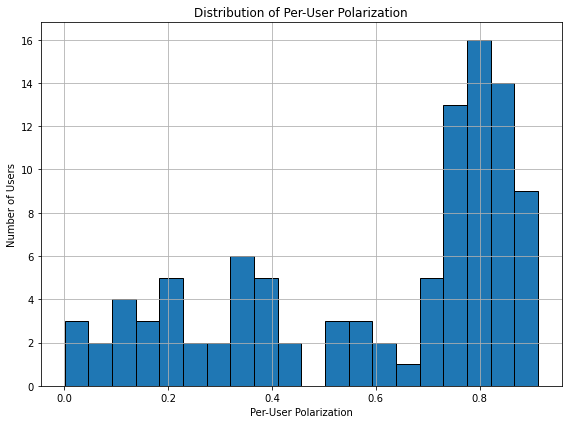

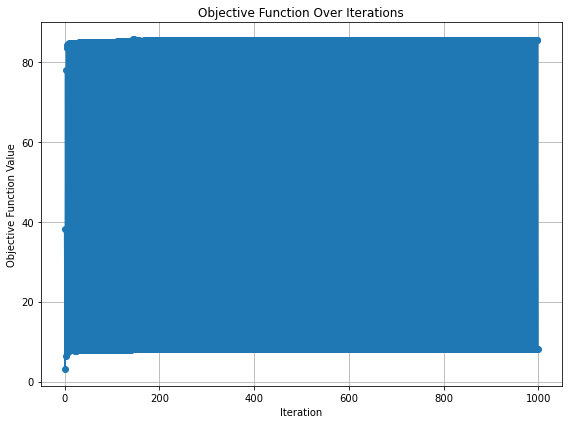

In [ ]:
# Example setup
if __name__ == "__main__":
    n_users = 100  # Adjust as needed
    n_content = 80
    np.random.seed(42)
    
    # Generate distributions and polarization scores
    a = np.random.rand(n_users, 1)
    a /= a.sum()
    b = np.random.rand(n_content, 1)
    b /= b.sum()
    C = np.random.rand(n_users, n_content)  # Cost matrix
    P = np.random.rand(n_content)  # Polarization scores
    
    # Parameters
    epsilon = 0.1
    lambda_p = 1.0  # Penalty weight
    precision = 1e-6
    max_iter = 1000
    
    # Run the modified Sinkhorn algorithm
    Pi, results = sinkhorn_with_per_user_penalty(
        C, a, b, P, epsilon, lambda_p, precision=precision, max_iter=max_iter
    )
    
    # Compute per-user polarization
    per_user_polarization = (Pi @ P) / a.flatten()
    
    # Print results
    print("Optimal transport plan computed.")
    print(f"Max per-user polarization: {np.max(np.abs(per_user_polarization)):.6f}")
    print(f"Average per-user polarization: {np.mean(np.abs(per_user_polarization)):.6f}")
    print(f"Sum over users (should equal a): {np.allclose(Pi.sum(axis=1, keepdims=True), a, atol=1e-6)}")
    print(f"Sum over content (should equal b): {np.allclose(Pi.sum(axis=0, keepdims=True).T, b, atol=1e-6)}")
    
    # Plotting per-user polarization distribution
    plt.figure(figsize=(8, 6))
    plt.hist(per_user_polarization, bins=20, edgecolor='black')
    plt.xlabel('Per-User Polarization')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Per-User Polarization')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plotting objective function over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(results['iterations'], results['objective_history'], marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function Over Iterations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
